In [1]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Formulating the optimization problem

$$
\begin{align*}
e &:= \text{energy on battery} \\
t &:= \text{point in time} \\
cost &:= \text{cost of charging}
\end{align*}
$$

$$
\begin{split}
\textrm{minimize } & \sum_{i=1}^{i=N}{cost_i}\\
\textrm{subject to:} &\\ 
\end{split}

\newline

\begin{align*}
e_{i+1} &= e_i - f(t_{i+1}, t_i, ...) &\text{ if } (t_{i+1} - t_i) \in \text{TRANSIT} \\
e_{i+1} &= e_i + \bar{P} \cdot (t_{i+1} - t_i) &\text{ if } (t_{i+1} - t_i) \in \text{DOCKED} \\
e_0 &= E_{init} \\
cost_i &= C_i \cdot \bar{P} \cdot (t_{i+1} - t_i) &\text{ if } (t_{i+1} - t_i) \in \text{DOCKED} \\
T_i^- &\le t_i \le T_i^+ &\forall i \in N \\
t_{i+1} - t_i &\ge \frac{D}{\bar{V}_{max}} &\forall i \in N-1 \\
E_{min} &\le e_i \le E_{max} &\forall i \in N \\
\end{align*}
$$

In [811]:
# Parameters
NUM_DEPARTURES = 6
N = 2 * NUM_DEPARTURES  # Number of 'time tokens' in the optimization problem
D = 10_000  # [meters]
TOO_EARLY_ARRIVAL_MAX = 15 * 60  # [seconds]
E_max = 4.3e6 # [Wh]
E_min = 0.2 * E_max # [Wh]
E_init = 0.5*E_max # [Wh]
E_end = 0.5*E_max # [Wh]
P = 1e6 # [W]
V_max = 6.5  # mean average speed [meters/second]

assert 0 < E_min < E_max
assert E_min <= E_init <= E_max
assert E_min <= E_end <= E_max

TS = [(lambda x: x*3600)(x) for x in range(NUM_DEPARTURES+1)]
print("Time schedule (arrival times):", TS)

print(f"Min travel time: {D/V_max:,.0f} seconds ({D/(3600*V_max):,.2f} hours)")
print(f"Max travel time wo/ stop: {3600*E_max/P:,.0f} sec ({E_max/P} hours))")
print(f"Max travel distance wo/ charging: {V_max * (3600*E_max/P):,.0f} meters")
# print(f"Max energy consumption: {P*")

Time schedule (arrival times): [0, 3600, 7200, 10800, 14400, 18000, 21600]
Min travel time: 1,538 seconds (0.43 hours)
Max travel time wo/ stop: 15,480 sec (4.3 hours))
Max travel distance wo/ charging: 100,620 meters


In [812]:
# Create model
m = pyo.ConcreteModel()
m.name = "Optimal Ferry Charging Schedule"

# Define variables
## Time
m.t = pyo.Var(range(N), within=pyo.NonNegativeReals)
m.t[0].fix(0)

# Energy
m.e = pyo.Var(range(N), within=pyo.NonNegativeReals, bounds=(E_min, E_max))
m.e[0].fix(E_init)
m.e[N-1].fix(E_end)

# Cost (Odd index numbers represent charging at the dock)
m.cost = pyo.Var(range(1, N-1, 2), domain=pyo.NonNegativeReals)


In [813]:
# Define constraints
## Time
def constraint_time_order(m, i):
    return m.t[i+1] >= m.t[i]
m.constraint_time_order = pyo.Constraint(range(N-1), rule=constraint_time_order)

def constraint_arrival_bounds(m, i):
    return m.t[i] <= TS[int(i/2)+1]
m.constraint_arrival_bounds = pyo.Constraint(range(1, N, 2), rule=constraint_arrival_bounds)

def constraint_min_timeslot_length(m, i):
    return m.t[i+1] - m.t[i] >= D/V_max
m.constraint_min_timeslot_length = pyo.Constraint(range(N-1), rule=constraint_min_timeslot_length)

## Energy
def constraint_energy_consumption(m, i):
    return m.e[i+1] == m.e[i] - (P/3) * (m.t[i+1] - m.t[i])/3600  # TODO: Replace this with the predicted consumption
m.constraint_energy_consumption = pyo.Constraint(range(0, N-1, 2), rule=constraint_energy_consumption)

def constraint_energy_charging(m, i):
    return m.e[i+1] == m.e[i] + 0.602*P * (m.t[i+1] - m.t[i])/3600
m.constraint_energy_charging = pyo.Constraint(range(1, N-1, 2), rule=constraint_energy_charging)

## Cost
def constraint_cost(m, i):
    return m.cost[i] == 10.0 * P * (m.t[i+1] - m.t[i])/3600
m.constraint_cost = pyo.Constraint(range(1, N-1, 2), rule=constraint_cost)

In [814]:
# Define objective function
def objective(m):
    return sum(m.cost[i] for i in range(1, N-1, 2))
m.objective = pyo.Objective(rule=objective, sense=pyo.minimize)

In [815]:
results = pyo.SolverFactory('cbc').solve(m)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 21367521.37
  Upper bound: 21367521.37
  Number of objectives: 1
  Number of constraints: 45
  Number of variables: 27
  Number of nonzeros: 5
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number 

In [816]:
points_in_time = list(m.t.extract_values().values())
begin = [x for x in points_in_time[:N]]
end = [x for x in points_in_time[1:]]

energy = list(m.e.extract_values().values())

cost = list(m.cost.extract_values().values())

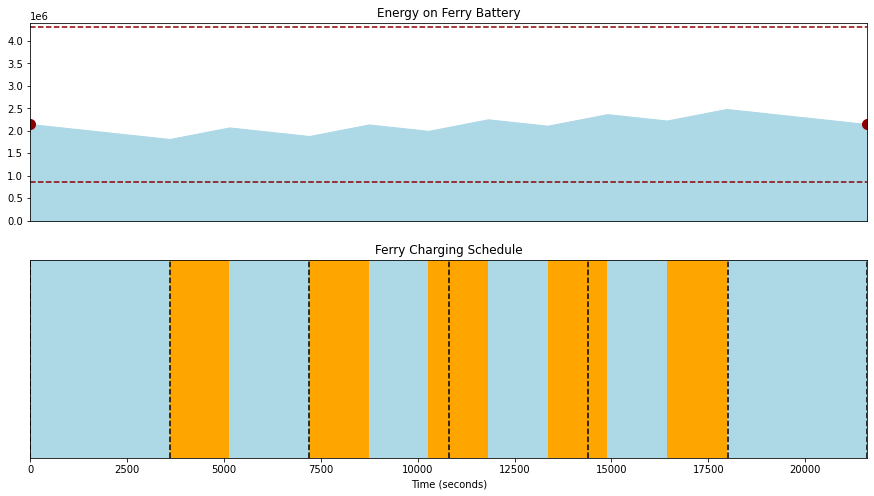

In [833]:
figs, axs = plt.subplots(nrows=2, figsize=(15, 8))

axs[0].fill_between(points_in_time, 0, energy, color='lightblue')
axs[0].add_line(plt.Line2D([TS[0], TS[-1]], [E_max, E_max], color='darkred', linestyle='--'))
axs[0].add_line(plt.Line2D([TS[0], TS[-1]], [E_min, E_min], color='darkred', linestyle='--'))
axs[0].scatter([TS[0], TS[-1]], [E_init, E_end], color='darkred', s=100)

axs[0].title.set_text("Energy on Ferry Battery")
axs[0].get_xaxis().set_visible(False)
axs[0].set_xlim(TS[0],TS[-1])
axs[0].set_ylim(0,E_max+1e5)

c = 'lightblue'
for x_1 , x_2 in zip(begin ,end):
    axs[1].add_patch(plt.Rectangle((x_1,0),x_2-x_1,1, color=c))
    if c == 'lightblue':
        c = 'orange'
    else:
        c = 'lightblue'

for t in TS:
    axs[1].add_line(plt.Line2D([t, t], [0, 1], color='black', linestyle='--'))

axs[1].title.set_text("Ferry Charging Schedule")
axs[1].set_xlabel("Time (seconds)")
axs[1].set_xlim(TS[0],TS[-1])
axs[1].get_yaxis().set_visible(False)
plt.show()

In [614]:
TS

[0, 3600, 7200, 10800, 14400, 18000, 21600]

In [504]:
m.display()

Model Optimal Ferry Charging Schedule

  Variables:
    t : Size=12, Index=t_index
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          0 :     0 :         0 :  None :  True :  True : NonNegativeReals
          1 :     0 :    6192.0 :  None : False : False : NonNegativeReals
          2 :     0 : 7730.4615 :  None : False : False : NonNegativeReals
          3 :     0 : 9268.9231 :  None : False : False : NonNegativeReals
          4 :     0 : 11582.462 :  None : False : False : NonNegativeReals
          5 :     0 :     21600 :  None :  True :  True : NonNegativeReals
          6 :     0 :   33984.0 :  None : False : False : NonNegativeReals
          7 :     0 :   71136.0 :  None : False : False : NonNegativeReals
          8 :     0 :   83520.0 :  None : False : False : NonNegativeReals
          9 :     0 :  120672.0 :  None : False : False : NonNegativeReals
         10 :     0 : 123248.82 :  None : False : False : NonNegativeReals
         11 :     0 : 12478